# Simulacion Historica de Portafolios
El objectivo de este ejercicio es construir una simulacion historica utilizando optimizacion de portafolios.

<div class="alert alert-block alert-warning">
<b>Nota:</b> Para optimizar un portafolio vamos a necesitar instalar el paquete scipy, primero.
</div>

<AxesSubplot:xlabel='date'>

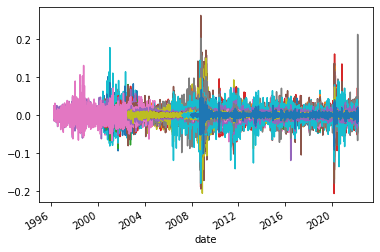

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import minimize

# Importar nuestra data
meta = pd.read_csv('etf_list.csv')
meta = meta.set_index('ticker')
rt_etf = pd.read_pickle('etf_er.pkl')
rt_etf.columns = [meta.loc[nemo, 'aesthetic'] for nemo in rt_etf.columns]

rt_etf.plot(legend=False)

### 1. Funciones Basicas
Vamos a crear las siguientes funciones, las cuales vamos a utilizar mas adelante:

\begin{align}
\mu_p &= w^{T}\mu \\
\sigma^{2}_p &= w^{T} \Sigma w \\
SR_{p} &= \frac{\mu_{p} - r_{f}}{\sigma_{p}}
\end{align}

Tambien vamos a crear una funcion que es el negativo del ratio de Sharpe, el cual vamos a utilizar durante la optimizacion de nuestro portfalio, mas adelante.

In [2]:
def retorno_portafolio(w, mu):
    ret_p = w.reshape(-1, 1).T @ mu.reshape(-1, 1)
    return ret_p.item()

def varianza_portafolio(w, sigma):
    var_p = w.reshape(-1, 1).T @ sigma @ w.reshape(-1, 1) 
    return var_p.item()

def sharpe_ratio(w, mu, sigma, rf=0):
    ret_p = retorno_portafolio(w, mu)
    var_p = volatilidad_portafolio(w, sigma)
    vol_p = np.sqrt(var_p)
    sr = (ret_p - rf) / vol_p
    return sr

def negativo_sharpe_ratio(w, mu, sigma, rf=0):
    ret_p = retorno_portafolio(w, mu)
    var_p = varianza_portafolio(w, sigma)
    vol_p = np.sqrt(var_p)
    sr = (ret_p - rf) / vol_p
    return -sr

### 2. Optimizando un portafolio
Primero, vamos a optimizar un portafolio, para buscar la combinacion de pesos que genera la minima varianza de portafolio, en un periodo especifico de tiempo. Cuando ya entendamos como funciona el optimizador, intentaremos hacer la simulacion historica (backtesting) del portafolio tangente. 

#### 2.1 Parametros

In [3]:
window = pd.DateOffset(years=5)  # Largo de la ventana de estimacion
dt = datetime(2021, 12, 31)  # Fecha de rebalanceo de prueba

muestra = rt_etf.loc[dt - window:dt]
n = muestra.shape[1]  # Numero de columnas
mu = muestra.mean().values * 252  # Vector de retornos
sigma = muestra.cov().values * 252  # Matriz de varianzas-covarianzas
w0 = np.array([1 / n] * n)  # Punto inicial

#### 2.2 Portafolio de minima varianza (sin restricciones)

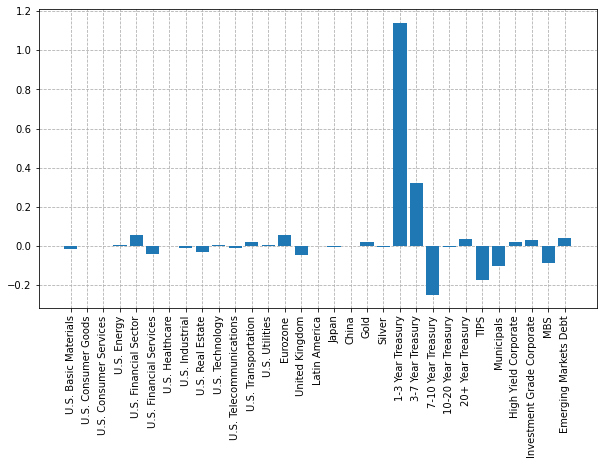

In [4]:
opt = minimize(
    fun=varianza_portafolio,
    x0=w0,
    args=[sigma]
)

w_mv = opt.x  # Solucion de minima varianza

# Dividamos los pesos por la suma de los pesos, asi sumaran 1
w_mv = w_mv / w_mv.sum()

# Veamos como se ven los resultados
fig, ax = plt.subplots(figsize=(10, 5.5))
ax.bar(x=muestra.columns, height=w_mv, zorder=100)
plt.xticks(rotation=90)
ax.grid(ls='--', zorder=-99)
plt.show()

#### 2.3 Aplicando restricciones a la optimizacion

\begin{equation}
  \begin{aligned}
  \operatorname*{argmin}_{\boldsymbol{w}} & \hskip 1em  \boldsymbol{w}^{T} \boldsymbol{\Sigma} \boldsymbol{w}\\
  \text{s.t.} & \hskip 1em \forall \boldsymbol{w} \geq 0\\
  & \hskip 1em \boldsymbol{w}^{T} \boldsymbol{1} = 1 \\
  \end{aligned}
\end{equation}

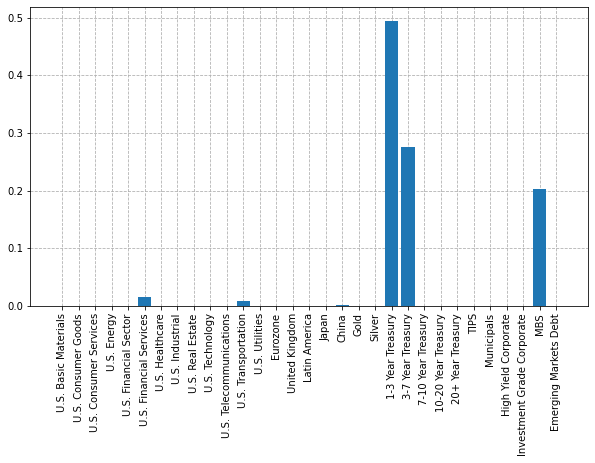

In [5]:
restricciones = (
    {'type': 'ineq', 'fun': lambda x:  x},  # No ventas cortas
    {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1}  # Capital 100% invertido
)

opt = minimize(
    fun=varianza_portafolio,
    x0=w0,
    args=[sigma],
    constraints=restricciones
)

w_mv = opt.x  # Solucion de minima varianza

# Veamos como se ven los resultados
fig, ax = plt.subplots(figsize=(10, 5.5))
ax.bar(x=muestra.columns, height=w_mv, zorder=100)
plt.xticks(rotation=90)
ax.grid(ls='--', zorder=-99)
plt.show()

### 3. Backtesting
Ahora vamos a realizar una simulacion historica, pero esta vez vamos a minimizar el negativo del ratio de Sharpe, lo que es equivalente a maximizar el ratio de Sharpe. 

El portafolio que maximiza el ratio de Sharpe es el portafolio tangente, de una frontera eficiente construido con estos sets de activos.

Vamos a asumir las siguientes reglas:
1. Si se permiten venta corta
2. Peso maximo de cada activo es 50%
3. Peso minimo de cada activo es -50%
4. El capital tiene que estar 100% invertido en cada rebalanceo
5. Los rebalanceos ocurriran el ultimo dia del mes

<div class="alert alert-block alert-warning">
<b>Nota:</b> Dado que estamos trabajando con series de retorno que ya estan en exceso de la libre de riesgo, no es necesario proveer $r_{f}$ en el ratio de Sharpe.
</div>

<AxesSubplot:title={'center':'Valor de nuestro portafolio (backtesting)'}>

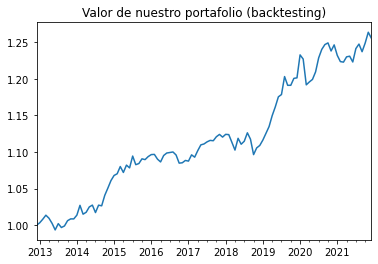

In [6]:
bt_start = datetime(2012, 12, 31)  # Inicio del backtesting
bt_end = datetime(2021, 12, 31)  # Termino del backtesting
fecha_rebalanceo = pd.date_range(bt_start, bt_end, freq='M')  # Fechas de rebalanceo (mensual)

restricciones = (
    {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1},  # Capital 100% invertido
    {'type': 'ineq', 'fun': lambda x:  x + .5},  # Capital 100% invertido
    {'type': 'ineq', 'fun': lambda x:  -x + .5}  # Capital 100% invertido
)

# Creamos nuestro DataFrame vacio donde vamos a guardar los resultados
pesos = pd.DataFrame(index=fecha_rebalanceo, columns=rt_etf.columns)

# Ahora el backtesting!
for dt in fecha_rebalanceo:
    # Estimacion de parametros
    muestra = rt_etf.loc[dt - window:dt]  # Muestra de datos diarios
    muestra = muestra.dropna(axis=1)  # Filtro por datos perdidos (botamos columnas no completas)
    n = muestra.shape[1]  # Numero de activos
    mu = muestra.mean().values * 252  # Vector de retornos
    sigma = muestra.cov().values * 252  # Matriz de varianzas-covarianzas
    w0 = np.array([1 / n] * n)  # Punto inicial
    
    # Optimizacion
    opt = minimize(
        fun=negativo_sharpe_ratio,
        x0=w0,
        args=(mu, sigma),
        constraints=restricciones
    )

    w_mv = opt.x  # Solucion de minima varianza
    w_mv = pd.Series(w_mv, index=muestra.columns)
    pesos.loc[dt] = w_mv

# Componer retornos diarios en mensuales
rt_etf_mensual = rt_etf.add(1).resample('M').prod().sub(1)

# Retornos de nuestra simulacion historica
rt_p = pesos.shift(1).mul(rt_etf_mensual).sum(axis=1)
rt_p = rt_p.reindex(fecha_rebalanceo)

# Ahora veamos como se ve nuestro portafolio
rt_p.add(1).cumprod().plot(title='Valor de nuestro portafolio (backtesting)')

In [7]:
# Cual fue el Sharpe Ratio historico de nuestro portafolio?
print(rt_p.mean() / rt_p.std() * np.sqrt(12))

0.8956470910195427
